# *Title**

# Introduction

test

# Preliminary Results

In [173]:
#install.packages("tidymodels")


In [174]:
library(tidyverse)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 6)

In [207]:
# Grabbing the data
url <- "https://gist.githubusercontent.com/zhonglism/f146a9423e2c975de8d03c26451f841e/raw/f79e190df4225caed58bf360d8e20a9fa872b4ac/vgsales.csv"
#Reading data into R
gaming_dataset <- read_csv(url)
#Selecting columns we need for our analysis
gaming_data <- gaming_dataset %>%
filter(
Year > 2001,
NA_Sales > 0) %>%
select(Name, Year, Platform, NA_Sales) |>
  mutate(Platform = if_else(Platform %in% c("DS", "GBA", "GB", "PSV", "PSP"), "Handheld", "Home Console"))

gaming_data

Rows: 16598 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Platform, Year, Genre, Publisher
dbl (6): Rank, NA_Sales, EU_Sales, JP_Sales, Other_Sales, Global_Sales

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Name,Year,Platform,NA_Sales
<chr>,<chr>,<chr>,<dbl>
Wii Sports,2006,Home Console,41.49
Mario Kart Wii,2008,Home Console,15.85
Wii Sports Resort,2009,Home Console,15.75
⋮,⋮,⋮,⋮
Woody Woodpecker in Crazy Castle 5,2002,Handheld,0.01
Men in Black II: Alien Escape,2003,Home Console,0.01
Spirits & Spells,2003,Handheld,0.01


(Figure 1.1)

Our dataset consists of the sales data for 10129 games released in North America after the year 2001. We chose to use this year as a cutoff because it is well into the initial popularization of handheld consoles by the original Game Boy. Including titles that were released significantly earlier than this point may cause home consoles to be overrepresented in the sample, as the handheld market practically did not exist prior to 1989. It is also the release date of the Game Boy Advance, a significant player in the handheld console market.

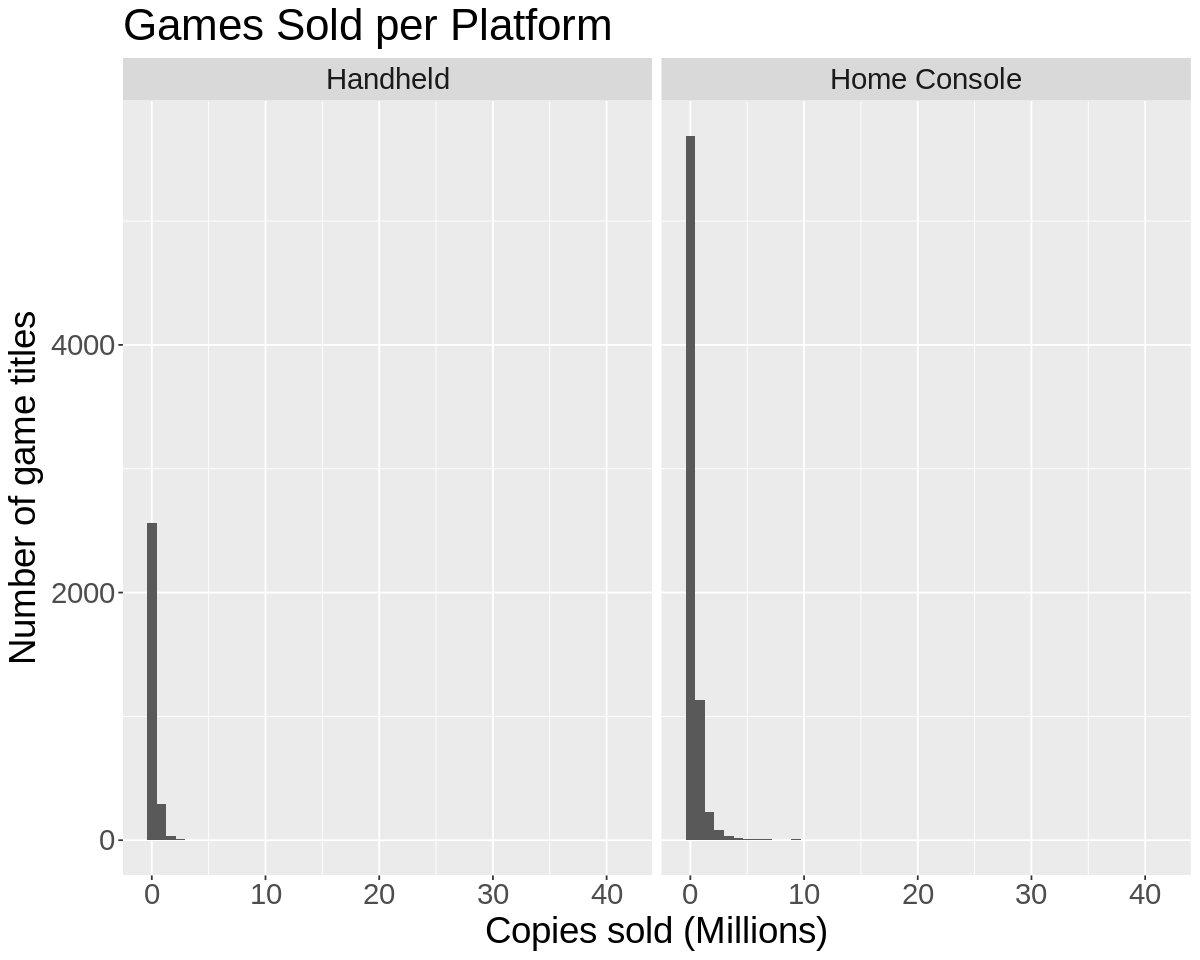

In [208]:
#Comparing the sampling distributions of handheld and home console systems in North America
gaming_data_dist_na <-
gaming_data %>%
ggplot() +
geom_histogram(aes(x = NA_Sales), bins = 50) +
facet_wrap(~ Platform) +
xlab("Copies sold (Millions)") +
ylab("Number of game titles") +
ggtitle("Games Sold per Platform")+
theme(text = element_text(size = 22))
gaming_data_dist_na

(Figure 1.2)

This is a plot of the global sales figures of our sample. It features a heavily right-skewed unimodal distribution. As is plainly visible, the number of total sales for home console systems eclipses that of the sales for handheld console systems. Despite this, the centers of the distributions appear to be fairly close to one another.

In [210]:
# Total sales
total_sales <-
    sum(gaming_data$NA_Sales)
total_titles <- NROW(gaming_data)
sum_stats <-
  gaming_data |>
  group_by(Platform) |>
  summarise(Num_Titles = n(),
            Sales_Total = sum(NA_Sales),
            Titles_Proportion = Num_Titles/total_titles,
            Sales_Proportion = Sales_Total/total_sales,
            Sales_Mean = mean(NA_Sales),
            Sales_SD = sd(NA_Sales))
sum_stats


Platform,Num_Titles,Sales_Total,Titles_Proportion,Sales_Proportion,Sales_Mean,Sales_SD
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Handheld,2912,667.83,0.2874914,0.2015963,0.2293372,0.5101972
Home Console,7217,2644.88,0.7125086,0.7984037,0.3664791,0.9114268


(Figure 1.3)

This table displays the total numbers for our dataset. The total number of titles and sales for each type of console are shown, as well as the proportion of titles and sales that each represent in the wider sample. We can see that the proportion of the titles for handheld systems is under-represented by their sales.

The table also displays sample estimates for our center and scale variables: mean and standard deviation, respectively. We chose to use these types of parameters because they are sensitive to outliers, which corresponds well to our heavily skewed dataset.

# Methods: Plan

# References